In [1]:
# Built-in modules
import os
import json
import shutil
import warnings
from os import path

# Libs
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3, VGG16
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.metrics import categorical_accuracy

# Own modules
import util

# Disable warnings
warnings.filterwarnings('ignore')

# __Image Classifier with Few Training Examples__

## __Abstract__
***

In this notebook, we build an image classifier using only very few training examples (\~1000 images per class). In particular, we define our model by attaching a new classifier (randomly initialized) on the pre-trained convolutional base of the InceptionV3 network. This model is then trained on images with real-time augmentations (e.g. rotation, shear, zoom, width and height shifts, horizontal flip). In addition, we make prediction using this model with a technique called test-time augmentation (TTA); that is, given an input image, our model makes predictions on multiple augmented copies of that image and return an ensemble prediction via soft voting. We train our model on the Food-101 dataset (https://kuanghuei.github.io/Food-101N/). The Food-101 dataset is designed for learning to address label noise with minimum human supervision (Lee, 2018), but we use it here because it is a dataset with very few instances for each class (\~1000 images per class). It is made up of 101 food categories with 101000 images where each image has been rescaled to have a maximum side length of 512 pixels. 

As depicted in the figure below, we define our model as follows: we take the pretrained InceptionV3 or VGG16 network, remove its trained classifier, and attach a fully connected classifier with an output layer appropriate for our purposes. That is, our model is made up two parts: a convolutional base and a classifier. 

<img src="img/feature_extraction.png" style="width:500px;height:350px">

We begin by investigating how to effectively train our model. For the sake of lower computational time, we perform various ways of training our model using only images from 10 classes. We explore the following ways of training our model:
- Freeze the entire convolutional base then re-train (call this the __baseline model__)
- Starting from the trained baseline model, unfreeze a few of the top layers of the convolutional base then re-train
- Starting from the trained baseline model, unfreeze the entire convolutional base then re-train

We evaluate each of these ways of training on the test set. We selet the one with the highest accuracy and use it to train a model using all 101 classes. Between InceptionV3 and VGG16, we find that using the convolutional base of InceptionV3, unfreezing it entirely and re-training it yields a model with the highest accuracy. With this approach trained on the entire dataset, our model achieves 80.8% accuracy on the test set. With test-time augmentation, this accuracy increases to 83.2%. 

## __Fetch Data__
***

The Food-101 dataset was downloaded from http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz. It consists of 101 food categories with 101000 images. For each class, there are 750 training images and 250 test images where each image have been rescaled to have a maximum side length of 512 pixels. 

In [2]:
if (not path.exists('data/food-101')):
    util.download()

In [3]:
labels = util.get_classes()
print(labels)

['churros', 'hot_and_sour_soup', 'samosa', 'sashimi', 'pork_chop', 'spring_rolls', 'panna_cotta', 'beef_tartare', 'greek_salad', 'foie_gras', 'tacos', 'pad_thai', 'poutine', 'ramen', 'pulled_pork_sandwich', 'bibimbap', 'beignets', 'apple_pie', 'crab_cakes', 'risotto', 'paella', 'steak', 'baby_back_ribs', 'miso_soup', 'frozen_yogurt', 'club_sandwich', 'carrot_cake', 'falafel', 'bread_pudding', 'chicken_wings', 'gnocchi', 'caprese_salad', 'creme_brulee', 'escargots', 'chocolate_cake', 'tiramisu', 'spaghetti_bolognese', 'mussels', 'scallops', 'baklava', 'edamame', 'macaroni_and_cheese', 'pancakes', 'garlic_bread', 'beet_salad', 'onion_rings', 'red_velvet_cake', 'grilled_salmon', 'chicken_curry', 'deviled_eggs', 'caesar_salad', 'hummus', 'fish_and_chips', 'lasagna', 'peking_duck', 'guacamole', 'strawberry_shortcake', 'clam_chowder', 'croque_madame', 'french_onion_soup', 'beef_carpaccio', 'fried_rice', 'donuts', 'gyoza', 'ravioli', 'fried_calamari', 'spaghetti_carbonara', 'french_toast', 'l

In [4]:
labels_10 = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
          'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']

For the purpose of utilizing the <code>ImageDataGenerator</code> class, copy the images from the <code>food-101</code> folder and split them into three folders:
- <code>101_classes/train</code>
- <code>101_classes/valid</code>
- <code>101_classes/test</code>

We do the same for the food categories listed in <code>labels_10</code>:
- <code>10_classes/train</code>
- <code>10_classes/valid</code>
- <code>10_classes/test</code>

In [8]:
if (not path.exists('data/101_classes')):
    util.create_train_and_validation_folders(labels, util.train_dir, util.valid_dir)
    util.create_test_folder(labels, util.test_dir)
    util.create_full_train_folder(labels, util.full_train_dir)

if (not path.exists('data/10_classes')):
    util.create_train_and_validation_folders(labels_10, util.train_10_dir, util.valid_10_dir)
    util.create_test_folder(labels_10, util.test_10_dir)
    util.create_full_train_folder(labels_10, util.full_train_10_dir)

We can check the number of images in the training, validation, and test sets contained in the <code>101_classes</code> folder.

In [6]:
datagen = ImageDataGenerator()
datagen.flow_from_directory(util.train_dir)
datagen.flow_from_directory(util.valid_dir)
datagen.flow_from_directory(util.test_dir);

Found 60600 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Similary, we can check the number of images in the training, validation, and test sets contained in the <code>10_classes</code> folder.

In [7]:
datagen.flow_from_directory(util.train_10_dir)
datagen.flow_from_directory(util.valid_10_dir)
datagen.flow_from_directory(util.test_10_dir);

Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


Below, let's display some of the images from our training dataset. 

Found 60600 images belonging to 101 classes.


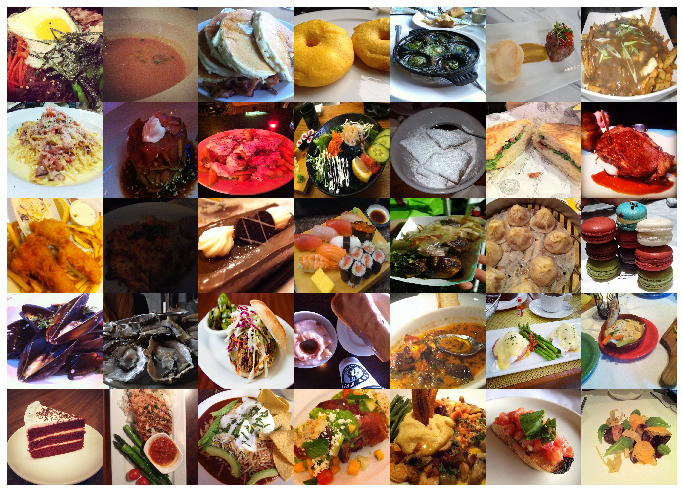

In [5]:
image_dim = 512
batch_size = 35 
datagen = ImageDataGenerator()
generator = datagen.flow_from_directory(
    util.train_dir, batch_size=35, target_size=(512, 512), shuffle=True);
images,_ = generator.next()
images = np.array(images, dtype=np.uint32)
util.plot_images(images, image_dim, images_per_row=7)

## __Data Preprocessing__
***

### __Data Augmentation__

We create two functions that returns an image generator given a directory containing images:
- <code>get_generator_with_augmentation()</code> returns a generator of augmented images such as rescaling, rotation, shear, zoom, width and height shifts, and horizontal flip. 
- <code>get_generator()</code> returns a generator of rescaled images. 

In [12]:
def get_generator_with_augmentation(image_dir, image_dim, batch_size):
    '''Return image generator with real-time augmentations such as: 
       rescaling, rotation, shear, zoom, width and height shifts, and horizontal flip.'''
    
    datagen = ImageDataGenerator(
        rescale=1.0/255, 
        rotation_range=45, 
        shear_range=0.2, 
        zoom_range=0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True, 
        fill_mode='nearest')
    generator = datagen.flow_from_directory(
        image_dir, 
        target_size=(image_dim, image_dim),
        batch_size=batch_size, 
        class_mode='categorical')
    return generator
    
def get_generator(image_dir, image_dim, batch_size, shuffle=True):
    '''Return image generator with rescaling only.'''
    
    datagen = ImageDataGenerator(rescale=1.0/255)
    generator = datagen.flow_from_directory(
        image_dir, 
        batch_size=batch_size,
        target_size=(image_dim, image_dim), 
        class_mode='categorical',
        shuffle=shuffle)
    return generator

To get a sample of how these augmentations look like when applied to the images in our dataset, let's apply them to a single image ('bibimbap/1285394.jpg')

In [13]:
single_folder = os.path.join('data', 'single_image')
util.create_folder_with_single_image(single_folder, 'bibimbap', '1285394.jpg')

<img src="data/single_image/bibimbap/bibimbap.jpg" style="width:200px;height:200px">

Found 1 images belonging to 1 classes.


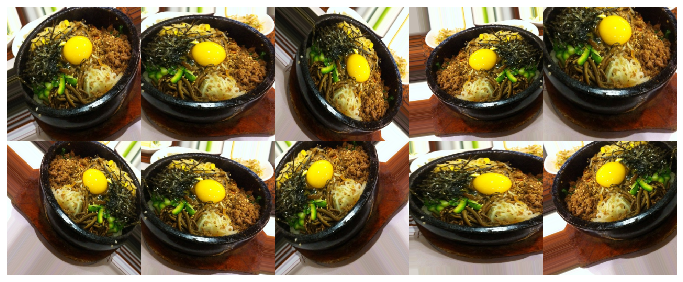

In [16]:
image_dim = 256
datagen = get_datagen_with_augmentation(rescale=1.0/255)
generator = get_generator_with_augmentation(single_folder, image_dim, batch_size=1)

counter = 0
augmented_images = []
for image,_ in generator:
    augmented_images.append(image[0])
    counter += 1
    if (counter == 10):
        break

util.plot_images(augmented_images, 256, 5)

### __Test Time Augmentation__

The following functions are used for test-time augmentations. In particular, <code>tta_evaluate()</code> will be used in the definition of our model in the next section.

In [19]:
def tta_predict(datagen, x, model, tta_steps):
    '''Return the predictions of the given model on the input x'''
    
    preds = []
    for i in range(tta_steps):
        tta_generator = datagen.flow(x, shuffle=False)
        pred = model.predict_generator(tta_generator)
        preds.append(pred)
    y_hat = np.sum(preds, axis=0)
    return y_hat

def tta_evaluate(model, test_generator, tta_steps=20, k=2):
    '''Evaluate the performance of the given model on the images produced
       by the test_generator'''
    
    correctly_labelled = 0
    images_sampled = 0
    num_images = len(test_generator.classes)
    datagen = get_datagen_with_augmentation(rescale=None)
  
    print('Test-Time Augmentation')
    print('Evaluate %d images...' % num_images)
    for x,y in test_generator:
        batch_size = y.shape[0]
        y_hat = tta_predict(datagen, x, model, tta_steps)
        images_sampled += batch_size
        
        if (images_sampled < num_images):
            correctly_labelled += np.sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))
        if (images_sampled == num_images):
            correctly_labelled += np.sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))
            break
        if (num_images < images_sampled + batch_size):
            break
            
        if (images_sampled % (k*batch_size) == 0):
            accuracy = correctly_labelled / images_sampled
            print('Number of images evaluated=%d, accuracy=%0.3f' % (images_sampled, accuracy))
    
    accuracy = correctly_labelled / images_sampled
    print('Number of images evaluated=%d, accuracy=%0.3f' % (images_sampled, accuracy))
    return accuracy

## __Define Model__
***

Below, we define our model. Our model is composed of the convolutional base of the InceptionV3 network and classifier that ends with a <code>Dense</code> layer with a <code>softmax</code> function.

In [32]:
class MyInceptionV3(tf.keras.Model):
   
    def __init__(self, input_shape, num_classes, conv_base_trainable=False):
        
        super(MyInceptionV3, self).__init__()
        self.conv_base = InceptionV3(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)
        
        # Convolutional Base
        self.conv_base.trainable = conv_base_trainable
        
        # Classifier portion
        self.pooling = GlobalAveragePooling2D()
        self.dense = Dense(1024, activation='relu')
        self.dropout = Dropout(0.5)
        self.out = Dense(num_classes, activation='softmax')
         
    def call(self, x):
        x = self.conv_base(x)
        x = self.pooling(x)
        x = self.dense(x)
        x = self.dropout(x)
        x = self.out(x)
        return x
    
    def evaluate_tta(self, generator, tta_steps=20, k=2):
        accuracy = tta_evaluate(self, generator, tta_steps, k)
        return accuracy

Convenience function for instantiating the model we defined above, building and compiling it as well to prepare it for fitting. 

In [33]:
def create_model(MyModel, num_classes, batch_size, image_dim, channels):
    input_shape = (image_dim, image_dim, channels)
    model = MyModel(input_shape, num_classes)
    model.build(input_shape=(batch_size, image_dim, image_dim, channels))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(lr=2e-5), 
                  metrics=[categorical_accuracy])
    return model

Below, we define a conveniece function for training a model on the given training and validation image generators. 

In [34]:
def train_model(model, epochs, train_generator, train_steps_per_epoch,
                valid_generator, valid_steps_per_epoch,
                weights_filepath, history_filepath):
   
    monitor = 'loss' if valid_generator == None else 'val_loss'
    csvlogger = CSVLogger(history_filepath)
    checkpointer = ModelCheckpoint(filepath=weights_filepath, monitor=monitor, verbose=1, 
                                   save_best_only=True, save_weights_only=True)
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=valid_steps_per_epoch, 
        callbacks=[csvlogger, checkpointer]).history
    
    return history

Function for plotting the results of running <code>train_model()</code>.

In [35]:
def plot_metrics(history):

    num_epochs = len(history)
    xs = [int(i) for i in range(1, num_epochs+1)]
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history['categorical_accuracy'], color='red', linestyle='solid')
    plt.plot(xs, history['val_categorical_accuracy'], color='blue', linestyle='solid')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid(linestyle='--')
    plt.legend(['training', 'validation'], loc='lower right');
    
    plt.subplot(1, 2, 2)
    plt.plot(xs, history['loss'], color='red', linestyle='solid')
    plt.plot(xs, history['val_loss'], color='blue', linestyle='solid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(linestyle='--')
    plt.legend(['training', 'validation'], loc='upper right');

## __Prototyping with 10 Classes__
***

We explore ways different ways of how to effectively train our model by using only images from 10 food categories. 

In [36]:
image_dim = 256
channels = 3
epochs = 20
num_classes = 10
batch_size = 30
train_generator = get_generator_with_augmentation(util.train_10_dir, image_dim, batch_size)
valid_generator = get_generator(util.valid_10_dir, image_dim, batch_size)

Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [37]:
train_steps_per_epoch = 6000//batch_size
valid_steps_per_epoch = 1500//batch_size

In [38]:
saved_folder = os.path.join('saved', '10_classes')
if (not os.path.exists(saved_folder)):
    os.makedirs(saved_folder)

### __Approach 1 - Freeze Convolutional Base Network__

Create an instance of our model and freeze all layers of the convolutional base. 

In [43]:
model = create_model(MyInceptionV3, num_classes, batch_size, image_dim, channels)
model.conv_base.trainable = False

In [44]:
weights_filepath = os.path.join(saved_folder, 'best_weights_InceptionV3_A.hdf5')
history_filepath = os.path.join(saved_folder, 'history_InceptionV3_A.log')

In [45]:
if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, epochs, train_generator, train_steps_per_epoch,
                          valid_generator, valid_steps_per_epoch,
                          weights_filepath, history_filepath)

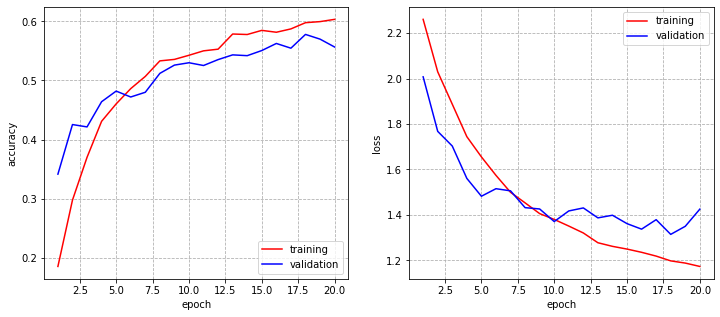

In [46]:
plot_metrics(history)

### __Approach 2 - Unfreeze some layers of Convolutional Base__ 

Create an instance of our model and load the weights from approach 1. 

In [47]:
model = create_model(MyInceptionV3, num_classes, batch_size, image_dim, channels)
model_A_best_weights = os.path.join(saved_folder, 'best_weights_InceptionV3_A.hdf5')
model.load_weights(model_A_best_weights)

Following the example from https://github.com/keras-team/keras/blob/master/docs/templates/applications.md#fine-tune-inceptionv3-on-a-new-set-of-classes
, we unfreeze the last 4 inception blocks. 

In [48]:
model.conv_base.trainable = True
for layer in model.conv_base.layers[:249]:
    layer.trainable = False
for layer in model.conv_base.layers[:]:
    layer.trainable = True

In [49]:
weights_filepath = os.path.join(saved_folder, 'best_weights_InceptionV3_B.hdf5')
history_filepath = os.path.join(saved_folder, 'history_InceptionV3_B.log')

In [50]:
if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, epochs, train_generator, train_steps_per_epoch,
                          valid_generator, valid_steps_per_epoch,
                          weights_filepath, history_filepath)

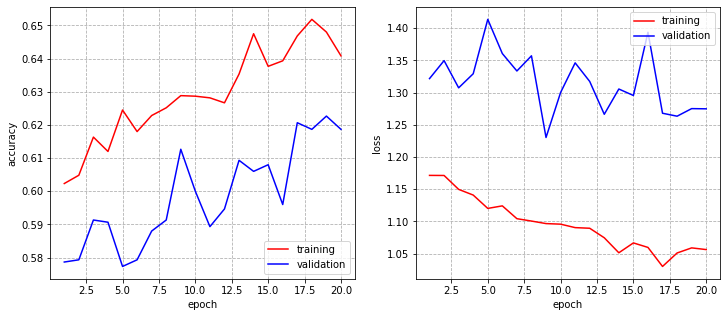

In [51]:
plot_metrics(history)

### __Approach 3 - Unfrozen Base Network__

Create an instance of our model and load the weights from approach 1. 

In [53]:
model = create_model(MyInceptionV3, num_classes, batch_size, image_dim, channels)
model_A_best_weights = os.path.join(saved_folder, 'best_weights_InceptionV3_A.hdf5')
model.load_weights(model_A_best_weights)

Unfreeze all layers of the entire convolutional base. 

In [54]:
model.conv_base.trainable = True
for layer in model.conv_base.layers:
    layer.trainable = True

In [55]:
weights_filepath = os.path.join(saved_folder, 'best_weights_InceptionV3_C.hdf5')
history_filepath = os.path.join(saved_folder, 'history_InceptionV3_C.log')

In [56]:
if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, epochs, train_generator, train_steps_per_epoch,
                          valid_generator, valid_steps_per_epoch,
                          weights_filepath, history_filepath)

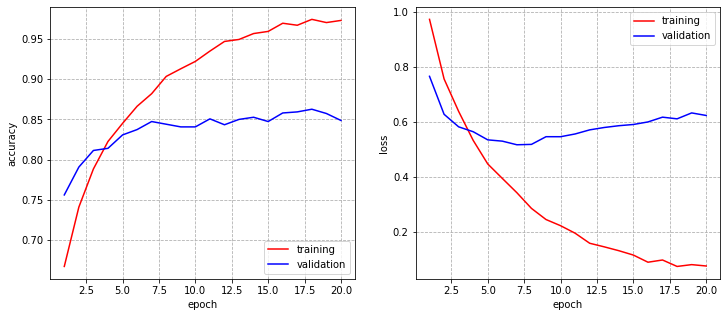

In [57]:
plot_metrics(history)

### __Final Model - 10 Classes__

From the different approaches above, we select approach 3 to construct our final model for images from 10 food categories. Below, we use this approach and train our final model on the full training set (<code>10_classes/train_dir</code> and <code>10_classes/valid_dir</code>). 

In [62]:
history_filepath = os.path.join(saved_folder, 'history_InceptionV3_C.log')
history = pd.read_csv(history_filepath)
optimal_epochs = np.argmin(history['val_loss'])

In [63]:
model = create_model(MyInceptionV3, num_classes, batch_size, image_dim, channels)
model_A_best_weights = os.path.join(saved_folder, 'best_weights_InceptionV3_A.hdf5')
model.load_weights(model_A_best_weights)

In [64]:
model.conv_base.trainable = True
for layer in model.conv_base.layers:
    layer.trainable = True

In [65]:
full_train_generator = get_generator_with_augmentation(util.full_train_10_dir, image_dim, batch_size)
full_train_steps_per_epoch = 7500//batch_size

Found 7500 images belonging to 10 classes.


In [66]:
weights_filepath = path.join(saved_folder, 'best_weights_InceptionV3_final.hdf5')
history_filepath = path.join(saved_folder, 'history_InceptionV3_final.log')

In [91]:
if (path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, optimal_epochs, full_train_generator, full_train_steps_per_epoch,
                          None, None, weights_filepath, history_filepath)

Epoch 1/6
249/250 [============================>.] - ETA: 0s - loss: 0.9789 - categorical_accuracy: 0.6458
Epoch 00001: loss improved from inf to 0.97930, saving model to saved/10_classes/best_weights_InceptionV3_final.hdf5
250/250 [==============================] - 171s 685ms/step - loss: 0.9793 - categorical_accuracy: 0.6460
Epoch 2/6
249/250 [============================>.] - ETA: 0s - loss: 0.7158 - categorical_accuracy: 0.7495
Epoch 00002: loss improved from 0.97930 to 0.71557, saving model to saved/10_classes/best_weights_InceptionV3_final.hdf5
250/250 [==============================] - 163s 653ms/step - loss: 0.7156 - categorical_accuracy: 0.7495
Epoch 3/6
249/250 [============================>.] - ETA: 0s - loss: 0.5692 - categorical_accuracy: 0.8096
Epoch 00003: loss improved from 0.71557 to 0.57005, saving model to saved/10_classes/best_weights_InceptionV3_final.hdf5
250/250 [==============================] - 172s 689ms/step - loss: 0.5701 - categorical_accuracy: 0.8096
Epoch

### __Performance on Test Set__

In [67]:
test_batch_size = 250
model = create_model(MyInceptionV3, num_classes, test_batch_size, image_dim, channels)
model.conv_base.trainable = True
for layer in model.conv_base.layers:
    layer.trainable = True
best_weights = os.path.join(saved_folder, 'best_weights_InceptionV3_final.hdf5')
model.load_weights(best_weights)

In [68]:
test_generator = get_generator(util.test_10_dir, image_dim, test_batch_size)
score = model.evaluate(test_generator, verbose=1)
print('Test accuracy: %0.3f' % score[1])

Found 2500 images belonging to 10 classes.
10/10 [==============================] - 52s 5s/step - loss: 0.3738 - categorical_accuracy: 0.8724
Test accuracy: 0.872


In [102]:
test_generator = get_generator(util.test_10_dir, image_dim, test_batch_size)
score = model.evaluate_tta(test_generator)
print('Test accuracy: %0.3f' % score)

Found 2500 images belonging to 10 classes.
Test-Time Augmentation
Evaluate 2500 images...
Number of images evaluated=500, accuracy=0.904
Number of images evaluated=1000, accuracy=0.905
Number of images evaluated=1500, accuracy=0.895
Number of images evaluated=2000, accuracy=0.894
Number of images evaluated=2500, accuracy=0.894
Test accuracy: 0.894


Test time augmentation improved accuracy by 2.2%

## __Model for 101 Classes__
***

We build a model for our entire dataset with 101 classses. To do this, we use approach 3 from the previous section. 

In [69]:
image_dim = 256
channels = 3
epochs=15
num_classes = 101
batch_size = 32
input_shape = (image_dim, image_dim, channels)
train_generator = get_generator_with_augmentation(util.train_dir, image_dim, batch_size)
valid_generator = get_generator(util.valid_dir, image_dim, batch_size)

Found 60600 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.


In [70]:
train_steps_per_epoch = 60600//batch_size
valid_steps_per_epoch = 15150//batch_size

In [71]:
saved_folder = os.path.join('saved', '101_classes')
if (not os.path.exists(saved_folder)):
    os.makedirs(saved_folder)

### __Freeze Convolutional Base Network__

In [73]:
model = create_model(MyInceptionV3, num_classes, batch_size, image_dim, channels)

In [74]:
model.conv_base.trainable = False

In [75]:
weights_filepath = os.path.join(saved_folder, 'best_weights_InceptionV3_A.hdf5')
history_filepath = os.path.join(saved_folder, 'history_InceptionV3_A.log')

In [76]:
if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, train_generator, valid_generator, epochs, train_steps_per_epoch, 
                          valid_steps_per_epoch, weights_filepath, history_filepath)

Best validation accuracy: 0.316068


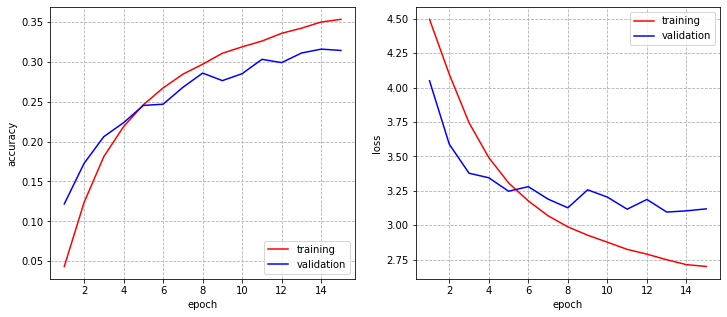

In [79]:
plot_metrics(history)
print('Best validation accuracy: %f' % history['val_categorical_accuracy'].max())

### __Unfrozen Base Network__

In [82]:
model = create_model(MyInceptionV3, num_classes, batch_size, image_dim, channels)
model_A_best_weights = os.path.join(saved_folder, 'best_weights_InceptionV3_A.hdf5')
model.load_weights(model_A_best_weights)

In [83]:
model.conv_base.trainable = True
for layer in model.conv_base.layers:
    layer.trainable = True

In [84]:
weights_filepath = os.path.join(saved_folder, 'best_weights_InceptionV3_C.hdf5')
history_filepath = os.path.join(saved_folder, 'history_InceptionV3_C.log')

In [85]:
if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, train_generator, valid_generator, epochs, train_steps_per_epoch, 
                          valid_steps_per_epoch, weights_filepath, history_filepath)

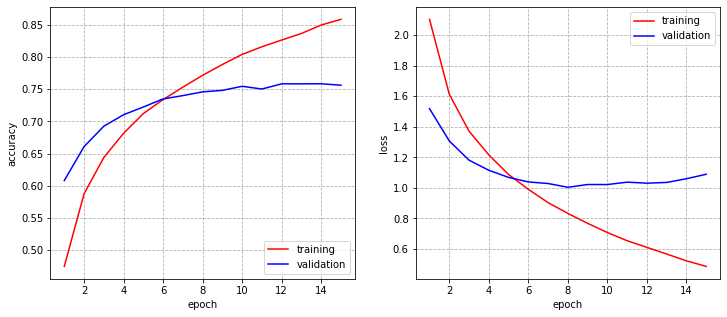

In [86]:
plot_metrics(history)

### __Final Model__

Train the model on the full training set (<code>10_classes/train_dir</code> and <code>10_classes/valid_dir</code>)

In [87]:
history_filepath = os.path.join(saved_folder, 'history_InceptionV3_C.log')
history = pd.read_csv(history_filepath)
optimal_epochs = np.argmin(history['val_loss'])

In [88]:
model = create_model(MyInceptionV3, num_classes, batch_size, image_dim, channels)
model_A_best_weights = os.path.join(saved_folder, 'best_weights_InceptionV3_A.hdf5')
model.load_weights(model_A_best_weights)

In [89]:
model.conv_base.trainable = True
for layer in model.conv_base.layers:
    layer.trainable = True

In [90]:
full_train_generator = get_generator_with_augmentation(util.full_train_dir, image_dim, batch_size)
full_train_steps_per_epoch = 75750//batch_size

Found 75750 images belonging to 101 classes.


In [91]:
weights_filepath = path.join(saved_folder, 'best_weights_InceptionV3_final.hdf5')
history_filepath = path.join(saved_folder, 'history_InceptionV3_final.log')

In [92]:
if (path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, optimal_epochs, full_train_generator, full_train_steps_per_epoch,
                          None, None, weights_filepath, history_filepath)

### __Performance on Test Set__

In [93]:
test_batch_size = 250
model = create_model(MyInceptionV3, num_classes, test_batch_size, image_dim, channels)
model.conv_base.trainable = True
for layer in model.conv_base.layers:
    layer.trainable = True
best_weights = os.path.join(saved_folder, 'best_weights_InceptionV3_final.hdf5')
model.load_weights(best_weights)

In [94]:
test_generator = get_generator(util.test_dir, image_dim, test_batch_size)

Found 25250 images belonging to 101 classes.


In [95]:
score = model.evaluate(test_generator, verbose=1)
print('Test accuracy: %0.3f' % score[1])

101/101 [==============================] - 480s 5s/step - loss: 0.7154 - categorical_accuracy: 0.8079
Test accuracy: 0.808


In [24]:
score = model.evaluate_tta(test_generator, k=4)
print('Test accuracy: %0.3f' % score)

Test-Time Augmentation
Evaluate 25250 images...
Number of images evaluated=1000, accuracy=0.853
Number of images evaluated=2000, accuracy=0.840
Number of images evaluated=3000, accuracy=0.844
Number of images evaluated=4000, accuracy=0.841
Number of images evaluated=5000, accuracy=0.843
Number of images evaluated=6000, accuracy=0.837
Number of images evaluated=7000, accuracy=0.836
Number of images evaluated=8000, accuracy=0.836
Number of images evaluated=9000, accuracy=0.835
Number of images evaluated=10000, accuracy=0.835
Number of images evaluated=11000, accuracy=0.834
Number of images evaluated=12000, accuracy=0.834
Number of images evaluated=13000, accuracy=0.834
Number of images evaluated=14000, accuracy=0.833
Number of images evaluated=15000, accuracy=0.834
Number of images evaluated=16000, accuracy=0.834
Number of images evaluated=17000, accuracy=0.833
Number of images evaluated=18000, accuracy=0.833
Number of images evaluated=19000, accuracy=0.833
Number of images evaluated=200

Test time augmentation improved accuracy by 2.4%

## __Conclusion__
***

We build a model that classifies images in the Food-101 dataset. This model is composed of the convolutional base of the pre-trained InceptionV3 network and a classifier with a <code>Dense</code> layer with a <code>softmax</code> function. We unfreeze all of the layers of the convolutional base and train it with real-time augmentation. We achieve an accuracy of 80.8% on the test set. With test-time augmentation, this accuracy increases to 83.2%. As a frame of reference, the most recent state of the art model I could find achieves an accuracy of 92.47% using a ResNet-50 network. 

## __References__
***

1. Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc, "_Food-101 -- Mining Discriminative Components with Random Forests_", European Conference on Computer Vision, 2014
2. Lee, Jungkyu and Won, Taeryun and Lee, Tae Kwan and Lee, Hyemin and Gu, Geonmo and Hong, Kiho, "_Compounding the Performance Improvements of Assembled Techniques in a Convolutional Neural Network_", 2020
3. Lee, Kuang-Huei and He, Xiaodong and Zhang, Lei and Yang, Linjun, "_CleanNet: Transfer Learning for Scalable Image Classifier Training with Label Noise_", 2018
4. Keskar, Nitish and Mudigere, Dheevatsa and Nocedal, Jorge and Smelyanskiy, Mikhail and Tang, Ping, "_On Large-Batch Training For Deep Learning: Generalization Gap and Sharp Minima_", ICLR, 2017. 

## __Appendix__
***

In [20]:
class MyVGG16(tf.keras.Model):
   
    def __init__(self, input_shape, number_of_classes, conv_base_trainable=False):
        
        super(MyVGG16, self).__init__()
        self.conv_base = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)
        self.conv_base.trainable = conv_base_trainable
        self.flatten = Flatten()
        self.dense = Dense(256, activation='relu')
        # Just like in VGG16 paper
        self.dropout = Dropout(0.5)
        self.out = Dense(number_of_classes, activation='softmax')
         
    def call(self, x):
        x = self.conv_base(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x)
        x = self.out(x)
        return x
    
    def evaluate_tta(self, generator, tta_steps=20, k=2):
        accuracy = tta_evaluate(self, generator, tta_steps, k)
        return accuracy

In [21]:
image_dim = 256
channels = 3
epochs = 20
num_classes = 10
batch_size = 30
train_generator = get_generator_with_augmentation(util.train_10_dir, image_dim, batch_size)
valid_generator = get_generator(util.valid_10_dir, image_dim, batch_size)

Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [22]:
train_steps_per_epoch = 6000//batch_size
valid_steps_per_epoch = 1500//batch_size

In [23]:
saved_folder = os.path.join('saved', '10_classes')
if (not os.path.exists(saved_folder)):
    os.makedirs(saved_folder)

### __Approach 1 - Freeze Convolutional Base Network__

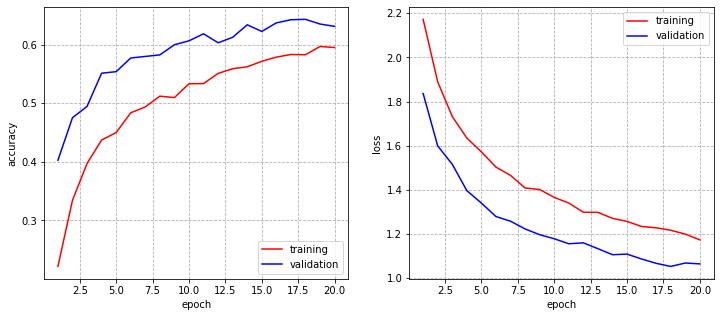

In [24]:
model = create_model(MyVGG16, num_classes, batch_size, image_dim, channels)
model.conv_base.trainable = False
weights_filepath = os.path.join(saved_folder, 'best_weights_VGG16_A.hdf5')
history_filepath = os.path.join(saved_folder, 'history_VGG16_A.log')
if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, epochs, train_generator, train_steps_per_epoch,
                          valid_generator, valid_steps_per_epoch,
                          weights_filepath, history_filepath)
plot_metrics(history)

### __Approach 2 - Unfreeze some layers of Convolutional Base__ 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

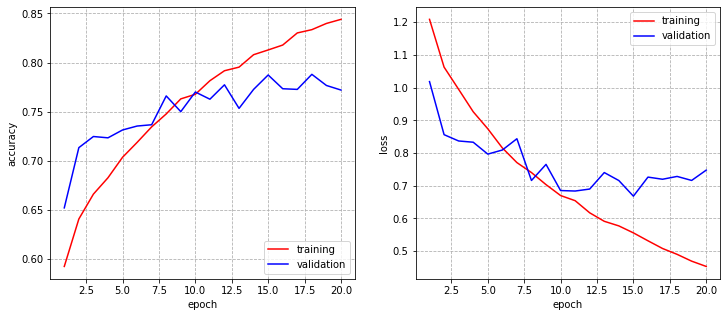

In [25]:
model = create_model(MyVGG16, num_classes, batch_size, image_dim, channels)
model_A_best_weights = os.path.join(saved_folder, 'best_weights_VGG16_A.hdf5')
model.load_weights(model_A_best_weights)
model.conv_base.summary()

model.conv_base.trainable = True
for layer in model.conv_base.layers:
    if 'block5_conv' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
        
weights_filepath = os.path.join(saved_folder, 'best_weights_VGG16_B.hdf5')
history_filepath = os.path.join(saved_folder, 'history_VGG16_B.log')

if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, epochs, train_generator, train_steps_per_epoch,
                          valid_generator, valid_steps_per_epoch,
                          weights_filepath, history_filepath)
plot_metrics(history)

### __Approach 3 - Unfrozen Base Network__

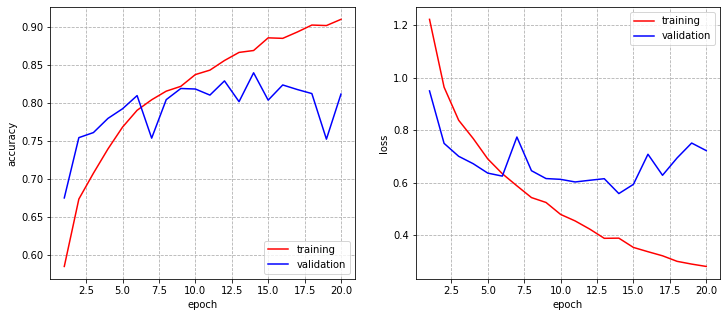

In [26]:
model = create_model(MyVGG16, num_classes, batch_size, image_dim, channels)
model_A_best_weights = os.path.join(saved_folder, 'best_weights_VGG16_A.hdf5')
model.load_weights(model_A_best_weights)

model.conv_base.trainable = True
for layer in model.conv_base.layers:
    layer.trainable = True
    
weights_filepath = os.path.join(saved_folder, 'best_weights_VGG16_C.hdf5')
history_filepath = os.path.join(saved_folder, 'history_VGG16_C.log')

if (os.path.exists(history_filepath)):
    history = pd.read_csv(history_filepath)
else:
    history = train_model(model, epochs, train_generator, train_steps_per_epoch,
                          valid_generator, valid_steps_per_epoch,
                          weights_filepath, history_filepath)

plot_metrics(history)

In [ ]:
for i, layer in enumerate(model.conv_base.layers):
    if ('mixed' in layer.name):
        print(i, layer.name)